In [1]:
from music21 import *
environment.Environment()['musicxmlPath'] = r'D:\Program Files\MuseScore 3\bin\MuseScore3.exe'
environment.Environment()['musescoreDirectPNGPath'] = r'D:\Program Files\MuseScore 3\bin\MuseScore3.exe'

### 首先创建 简谱-规则
因为手里的谱子是简谱，因此需要创建一个从简谱到音名的一一对应规则
- 长音：1-
- 下加线：<1>
- 延长半音：1.
- 小节线：|
- 低音：(1)
- 高音：[1]
- 升音：1#
- 降音：1b

在此基础上定义“音符类”，用来将数字简谱中的每个音所对应的时值、音高、升降等信息记录下来：

In [2]:
PitchClass = ['C','D','E','F','G','A','B']
TypeClass = ['64th','32nd','16th','eighth','quarter','half','whole']   
class StrNote:
    '''
     对音符的字符串信息进行保存
     分别存储pitch，octave ,accidental，并最终拼接起来
    '''
    def __init__(self):
        '''
            默认简谱中的do是C5
            因此是pitch下标为0
            中音的八度octave是第五个
            没有升降号accidental 
            默认是四分之一音符4
            默认没有附点
        '''
        self.pitch = 0
        self.octave = 5
        self.accidental = ''
        self.type = 4
        self.dot = 0
        
    def __init__(self,pitch):
        '''
          有参构造
        '''
        self.pitch = pitch-1
        self.octave = 5
        self.accidental = ''
        self.type = 4
        self.dot = 0
            
    def __add__(self, y):
        '音调pitch加一位'
        self.pitch = (self.pitch+y)%7
        return self
        
    def __sub__(self,y):
        '音调pitch减一位'
        self.pitch = (self.pitch+7-y)%7
        return self
    
    def setflat(self):
        '降音'
        self.accidental = 'b'
    
    def setsharp(self):
        '升音'
        self.accidental = '#'
    
    def setnormal(self):
        '变成普通音'
        self.accidental = ''
        
    def higher(self):
        '提高一个八度'
        self.octave += 1 
        
    def lower(self):
        '降低一个八度'
        self.octave -= 1 
    
    def longer(self):
        '时间加长'
        if self.type == 5 and self.dot == 0:
            self.dot = 1
        else:
            self.type += 1
            
    def shotter(self):
        '时间减短'
        self.type -= 1
    
    def adddot(self):
        '添加附点'
        self.dot += 1
        
    def getstr(self):
        '返回这个音的字符串'
        return str(PitchClass[self.pitch]) + str(self.octave) + str(self.accidental)
        
    
    def getnote(self):
        if self.pitch == -1:
            stopnote = note.Rest(1)
            stopnote.duration.type = TypeClass[self.type]
            stopnote.duration.dots = self.dot
            return stopnote
        '返回音符对象'
        thisnote = note.Note(str(PitchClass[self.pitch]) + str(self.octave) + str(self.accidental))
        thisnote.duration.type = TypeClass[self.type]
        thisnote.duration.dots = self.dot
        return thisnote
 
'''判断是数字还是符号'''
def isnum(input):
    try:
        int(input)
        return True
    except:
        return False

定义字符串->乐谱的函数，用来将字符串转换成乐谱

In [3]:
'''
Summay:
    将字符串简谱转换成音乐流
Parameters:
    music_str - 简谱字符串  str
    play_it - 是否播放      bool
Return：
    s - Music21格式的音乐流 stream
'''
def str2stream(music_str,play_it = True):
    out_put = open('out.txt','w')
    notelist = []
    s = stream.Score(id='mainScore')
    '''
    lowerflag  -  低音标志()
    higherflag -  高音标志[]
    shotterflag - 短时标志<>
    longgerflag - 长时标志--
    
    '''
    lowerflag = False
    higherflag = False
    sharpflag = False
    shotterflag = 0
    measurenum = 1
    for each in music_str:
        #print(each)
        if isnum(each):
            midnote = StrNote(int(each))
            if lowerflag == True:
                midnote.lower()
            if higherflag == True:
                midnote.higher()
            if shotterflag != 0:
                for i in range(shotterflag):
                    midnote.shotter()
            if sharpflag == True:
                midnote.setsharp()
                #print(midnote)
                sharpflag = False
            notelist.append(midnote)
        else:
            if each == '(':
                lowerflag = True
            elif each == ')':
                lowerflag = False
            elif each == '[':
                higherflag = True 
            elif each == ']':
                higherflag = False 
            elif each == '<':
                shotterflag += 1 
            elif each == '>':
                shotterflag -= 1
            elif each == '.':
                notelist[len(notelist)-1].adddot()
            elif each == '-':
                notelist[len(notelist)-1].longer()
            elif each == '#':
                #sharpflag = True
                notelist[len(notelist)-1].setsharp()
            elif each == 'b':
                notelist[len(notelist)-1].setflat()
            elif each == '|':
                midstream = stream.Measure(number=measurenum)
                measurenum+=1
                for eachnote in notelist:
                    out_put.write(eachnote.getstr()+'\n')
                    midstream.append(eachnote.getnote())
                
                s.append(midstream)
                notelist.clear()
            else:
                continue
    
    if len(notelist)!= 0:
        midstream = stream.Measure(number=measurenum)
        for eachnote in notelist:
            out_put.write(eachnote.getstr()+'\n')
            midstream.append(eachnote.getnote())
        s.append(midstream)

        notelist.clear()
    if play_it == True:play(s)
    out_put.close()
    return s


def str2tone(music_str):
    out_put = open('out.txt','w')
    notelist = []
    s = stream.Score(id='mainScore')
    '''
    lowerflag  -  低音标志()
    higherflag -  高音标志[]
    shotterflag - 短时标志<>
    longgerflag - 长时标志--
    
    '''
    lowerflag = False
    higherflag = False
    sharpflag = False
    shotterflag = 0
    measurenum = 1
    for each in music_str:
        #print(each)
        if isnum(each):
            midnote = StrNote(int(each))
            if lowerflag == True:
                midnote.lower()
            if higherflag == True:
                midnote.higher()
            if shotterflag != 0:
                for i in range(shotterflag):
                    midnote.shotter()
            if sharpflag == True:
                midnote.setsharp()
                #print(midnote)
                sharpflag = False
            notelist.append(midnote)
        else:
            if each == '(':
                lowerflag = True
            elif each == ')':
                lowerflag = False
            elif each == '[':
                higherflag = True 
            elif each == ']':
                higherflag = False 
            elif each == '<':
                shotterflag += 1 
            elif each == '>':
                shotterflag -= 1
            elif each == '.':
                notelist[len(notelist)-1].adddot()
            elif each == '-':
                notelist[len(notelist)-1].longer()
            elif each == '#':
                #sharpflag = True
                notelist[len(notelist)-1].setsharp()
            elif each == 'b':
                notelist[len(notelist)-1].setflat()
    
    return notelist[0].getstr()

在return s之前有一个魔法函数play(将会在下面定义)，他的作用是阻止一个bug的发生，就像下面这样：

'B5#'

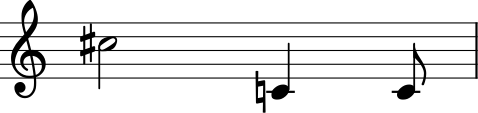

In [5]:
s = stream.Score(id='mainScore')
m = stream.Measure(number=1)
m.append(note.Note('C5#', type="half"))
m.append(note.Note('C', type="quarter"))
m.append(note.Note('C', type="eighth"))
s.append(m)
s.show()
s.show('midi')

可以听出来，刚才这段音频只播放了后面两个音，而用了魔法函数就能解决这个问题(我也不知道为什么)

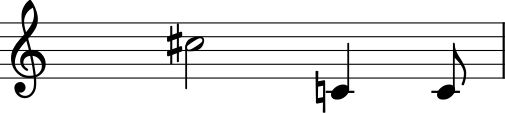

In [6]:
'''
Summay:
    播放Music21格式的流，显示谱子+播放音乐
Parameters:
    x - Music21格式的流  stream

'''
def play(x):
    """Returns nothing. Outputs a midi realization of x, a note or stream.
    Primarily for use in notebooks and web environments.
    """
    if isinstance(x, stream.Stream):
        # x = copy.deepcopy(x)
        for subStream in x.recurse(streamsOnly=True, includeSelf=True):
            mss = subStream.getElementsByClass(stream.Measure)
            for ms in mss:
                ms.offset += 1.0
    if isinstance(x, note.Note):
        s = stream.Stream()
        s.append(note.Rest(1))
        s.append(x)
        x = s
    x.show()
    x.show('midi')
play(s)

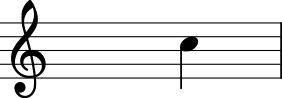

PermissionError: [Errno 13] Permission denied: '/do.mid'

In [8]:
do = '1'
do_stream = str2stream(do)

In [9]:
do_stream.write('midi','do.mid')

'do.mid'

可以听出来，现在音已经全了。
### 根据规则写简谱
接下来我们要根据规则写简谱，规则如果忘了的话可以再看一遍
- 长音：1-
- 下加线：<1>
- 延长半音：1.
- 小节线：|
- 低音：(1)
- 高音：[1]
- 升音：#1
- 降音：b1
除了<>这个符号是我自己加的以外，剩下的规则都和现在大家用的数字谱一样

首先我们生成一段两个小节的音频：

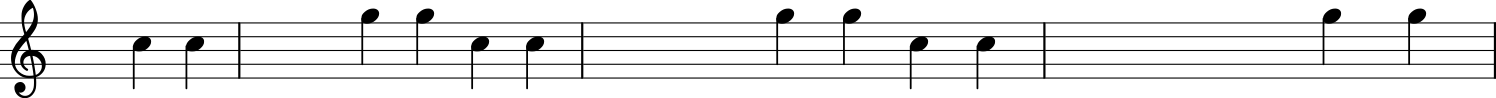

<music21.stream.Score mainScore>

In [7]:
s1 = '11|5511|5511|55'
str2stream(s1)

如果在55后面加了一个|可能会更加的标准，表示最后一个小节的结束，不过没什么所谓，因为加不加都可以

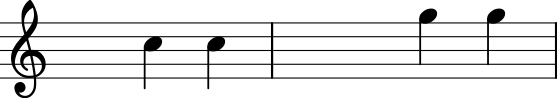

<music21.stream.Score mainScore>

In [21]:
s = '11|55|'
str2stream(s)

接下来是延长音、下划线(我不知道叫啥)以及附点

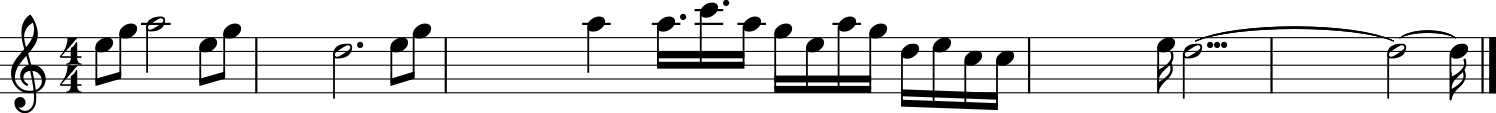

<music21.stream.Score mainScore>

In [18]:
s = '<35>|6-<35>|2--<35>6<<6.[1].6536523113>>|2---'
str2stream(s)

可以看到延长音从-、--、--都是可以的。下划线的<>可以进行嵌套.附点的话会将前一个音的时间拉长一半。比如原来2响1秒钟，2.就是响1.5秒钟；2响0.75秒，2.就是1.075秒(0.75+0.375)。以此类推

接下来是升降

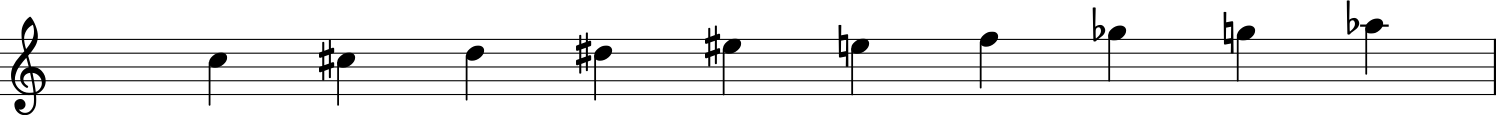

<music21.stream.Score mainScore>

In [54]:
s = '1 1# 2 2# 3# 3 4 5b 5 6b'
str2stream(s)

其实这里不用空格，不过为了保持美观整洁，就把音符都空格开了

最后是高音低音，就在音的外面套个括号就行了

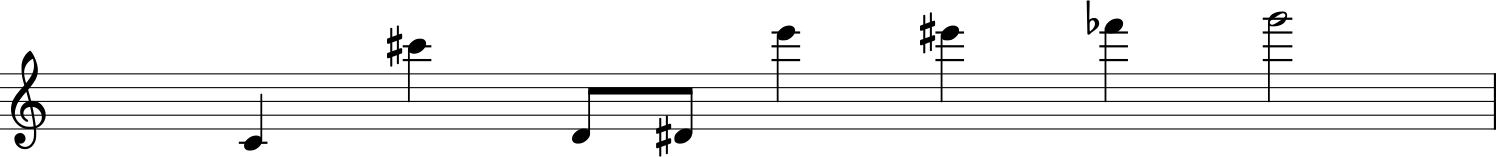

<music21.stream.Score mainScore>

In [10]:
s = '(1) [#1] <(2 #2)> [3 #3 4 b5-] '
str2stream(s)

接下来是我已经写好了的几个谱子

In [5]:
# 小星星
star = '11|55|66|5-|44|33|22|1-|55|44|33|2-|55|44|33|2-|11|55|66|5-|44|33|22|1-'
# 欢乐颂
happy = '3345|5432|1123|3.<2>2-|3345|5432|1123|2.<1>1-|2231|2<34>31|2<34>32|12(5)3-|345|543<42>|1123|2.<1>1-'
# 多年以后
manyyears = '1<12>|3<34>|5<65>|3-|5<43>|2-|'
manyyears += '4<32>|1-|1<12>|3<34>|5<65>|3-|'
manyyears += '5<43>|2<32>|1-|1-|5<43>|2<(55)>|'
manyyears += '4<32>|1-|5<43>|2<(55)>|4<32>|1-|'
manyyears += '1<12>|3<34>|5<65>|3-|5<43>|2<32>|1-|1-'

# 灵儿响叮当
bring = '<33>3|<33>3|<351.<2>>|3-|<44>4|<43>3|<3223>|'
bring += '25|<33>3|<33>3|<351.<2>>|3-|<44>4|<43>3|'
bring += '<5542>|1-|<(5)321>|(5)-|<(5)321>|(6)-|<(6)432>|'
bring += '(7)-|<5542>|3-|<(5)321>|(5)-|<(5)321>|(6)-|'
bring += '<(6)432>|<55>5|<6542>|1-|<33>3|<33>3|<351.<2>>|'
bring += '3-|<44>4|<43>3|<3223>|25|<33>3|<33>3|'
bring += '<351.<2>>|3-|<44>4|<43>3|<5542>|1[1]'

# 你和蔷薇一样美丽啊啊啊啊啊啊啊
aaaa = '<<(67)>#1.<0>>|<<#1.(76)>>#4.|<#1(766<#4>)>|#1.<(7)>'
aaaa +='<<(67)>#1.<0>>|<<#1.(76)>>#4.|<#1(766<#4>)>|#1.<(7)>'
aaaa +='<<(67)>#13.>|<3#4#1<(76)>> |<0> |<<(67)>#13> |<3#4#1<(76)>>0'
aaaa += '(<#4<0>67>)|<<1.(7.>6#4)>|#1.<2<#1>>(7)'

aaaa +='<<(67)>#1.<0>>|<<#1.(76)>>#4.|<#1(766<#4>)>|#1.<(7)>'
aaaa +='<<(67)>#1.<0>>|<<#1.(76)>>#4.|<#1(766<#4>)>|#1.<(7)>'
aaaa +='<<(67)>#13.>|<3#4#1<(76)>> |<0> |<<(67)>#13> |<3#4#1<(7>6)>'
aaaa +='<(6)<#13>#4.<0>3.#4#1(7. <0> 6<#467>6-)>'

aaaa +='<#1(<7>6-#5<3>#5-673)3<2#>>1'
aaaa +='<(6)#13#4-> | <3<#4#1>(7. 6<#467>6-)>'
aaaa +='<(3)2#1(7<6>6)| <(3)2#1>(7<6>6.) | <(3)2#1>(7<6>6.) | <(3)2#1>(7<6>7.)>'
aaaa +='<<(67)>#1#1|#3#1(<7>6-)| (6)#43#4|3#1(7>6)'
aaaa +='<(6)<6#46>>|6---'


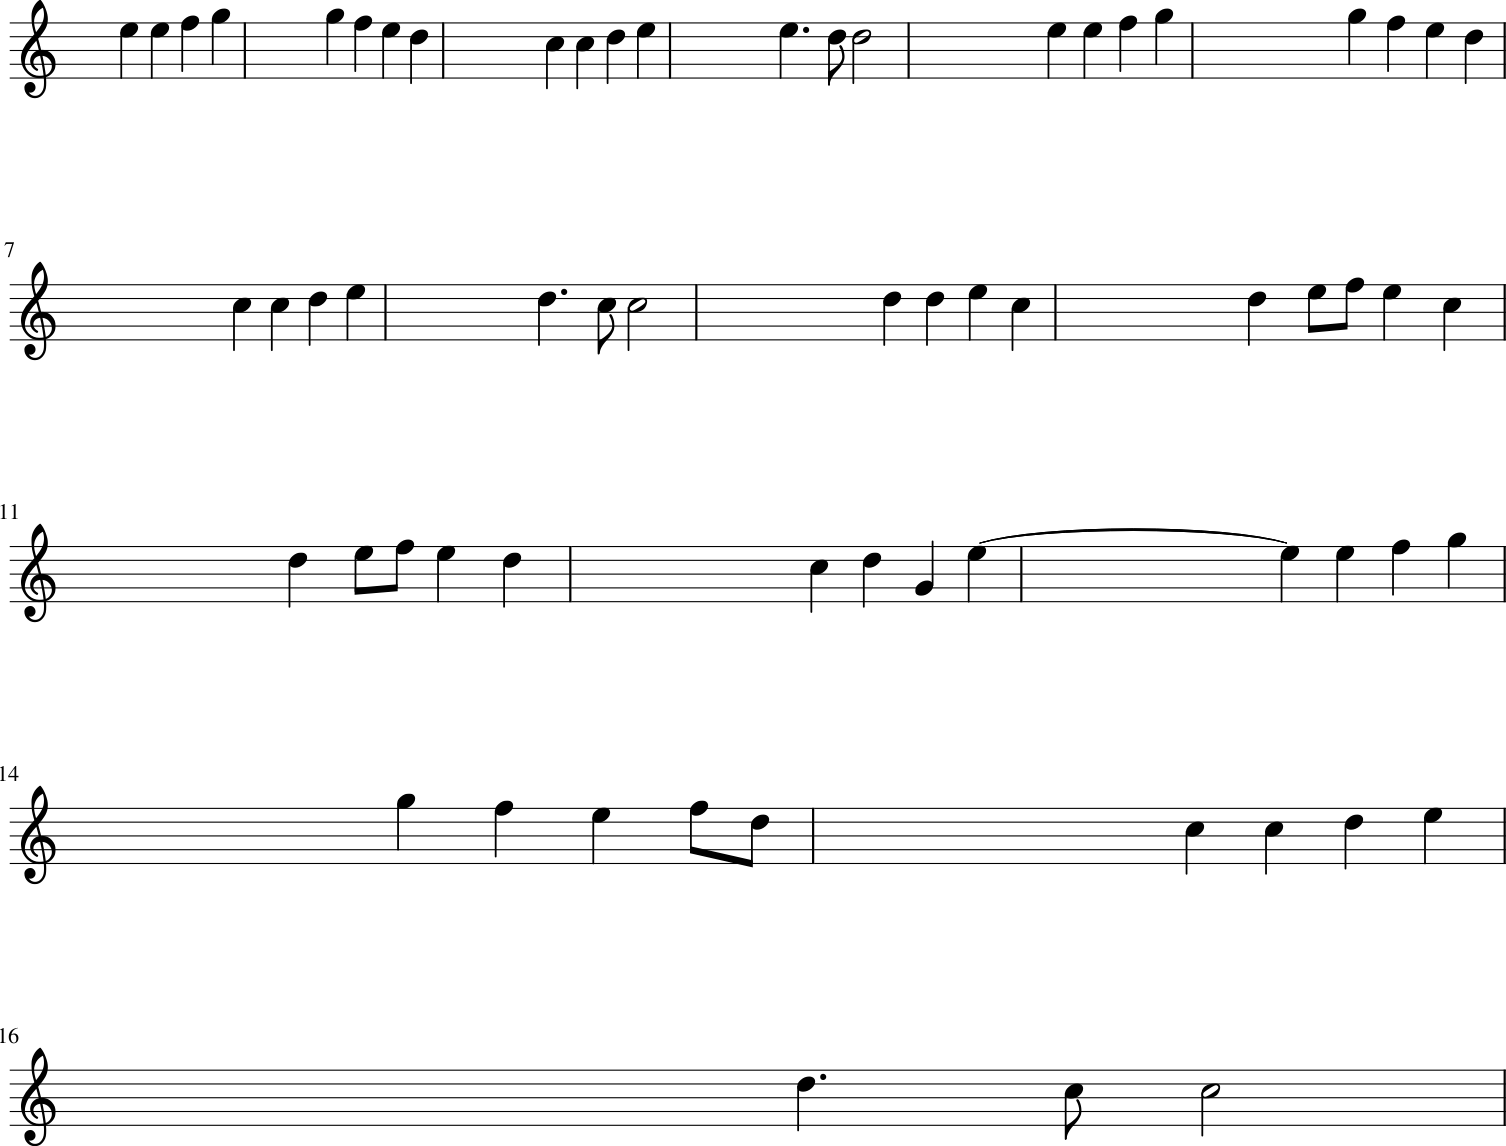

In [6]:
s = str2stream(happy)

In [13]:
path = r'.\happy.mid' 
wv = s.write('midi', fp=path)

### 随机生成乐谱
使用random的方式，将每个音符分为两部分的组合，进行乐谱生成。
- random一个音符，[1,7]
- random是否要有`[ , ( ， < `，有的话做相应的记录，has_high，has_low, has_fast。其中前两个排斥，都和最后一个不排斥。
- 如果上述三个存在一个是True，那么下一个音符就要相应的用随机数来生成另一半。
- 4个音符一小节，最后一小节把前面所有的有has_high，has_low, has_fast的都给补上
- 每个音符随机判断是否有`# , b , - , .`

In [6]:
tone_list = ['1','2','3','4','5','6','7']

import random
'''
Summary:
    制作一个音调
'''
def MakeStrTone():
    # 随机选择音调
    tone = random.choice(tone_list) 
    
    # 是否高低
    # if random.randint(0, 1) == 0:
    
    if random.randint(0, 1) == 0:
        if random.randint(0, 1) == 0:
            tone = tone+'#'
        else:
            tone = tone+'b'
        
        
    # 没有被高音
    if has_high == False:
        # 添加高音
        if random.randint(0, 1) == 0:
            tone = '['+tone
            has_high = True
    # 没有被低音
    elif has_high == False and has_low == False:
    #if has_low == False:
        # 添加低音
        if random.randint(0, 1) == 0:
            tone = '('+tone
            has_low = True
    else:
        if has_high == True:
            # 去掉高音
            if random.randint(0, 1) == 0:
                tone = tone+']'
                has_high = False
        elif has_low == True:
            # 去掉低音
            if random.randint(0, 1) == 0:
                tone = tone+')'
                has_low = False       
    # 没有被加快
    if has_fast == False:
        # 添加高音
        if random.randint(0, 1) == 0:
            tone = '<'+tone
            has_fast = True
    # 被加快了
    else:
        # 降下来
        if random.randint(0, 1) == 0:
            tone = tone+'>'
            has_fast = False
    
    return tone, has_high, has_low, has_fast



'''
Summary:
    制作一个音调
'''
def MakeStrTone2():
    # 随机选择音调
    tone = random.choice(tone_list) 
    
    # 是否升降
    if random.randint(0, 1) == 0 and tone not in ['3','7']:
        pan = random.randint(0, 2)
        if pan == 0:
            tone = tone+'#'
        
    # 是否高低
    if random.randint(0, 1) == 0:
        pan = random.randint(0, 2)
        if pan == 0:
            tone = '['+tone+']'
        elif pan == 1:
            tone = '('+tone+')'
    
    # 是否延长/缩短
    if random.randint(0, 1) == 0:
        pan = random.randint(0, 1)
        # 延长
        if pan == 0:
            # 0是 1是- 2是-- 3是---
            pan = random.randint(0, 3)
            if pan == 1:
                tone =  tone + '-'
            elif pan == 2:
                tone =  tone + '--'
            elif pan == 3:
                tone =  tone + '---'
        else:
            tone = '<'+ tone + '>'
            pan = random.randint(0, 2)
            if pan == 0:
                tone = '<'+ tone + '>'
            elif pan == 1:
                tone = tone + '.'
                
        
    
    return tone
    
'''
Summary:
    制作一个谱子
'''
def MakeStrScore(tones_num=10):
    has_high,has_low, has_fast = False,False,False
    Score = ''
#     for i in range(tones_num):
#         tone, has_high, has_low, has_fast = MakeStrTone( has_high,has_low, has_fast)
#         Score += tone
#         if i%4 == 0:
#             Score += '|'
#     if has_high == True:
#         Score = Score+']'
#     if has_low == True:
#         Score = Score+')'
#     if has_fast == True:
#         Score = Score+'>'
#     print(Score)
    ScoreList = []
    for i in range(tones_num):
        mytone = MakeStrTone2() 
        Score += mytone
        ScoreList.append(str2tone(mytone))
        if i%4 == 0:Score += '|'
    return Score,ScoreList


In [11]:
string_s,string_list = MakeStrScore(20)

In [12]:
string_s,string_list

('5|7-21<(5#)>|5--<6>1--[5]|<<3>>2--<6>.6|31---(6#)---4|7(7)---5',
 ['G5',
  'B5',
  'D5',
  'C5',
  'G4#',
  'G5',
  'A5',
  'C5',
  'G6',
  'E5',
  'D5',
  'A5',
  'A5',
  'E5',
  'C5',
  'A4#',
  'F5',
  'B5',
  'B4',
  'G5'])

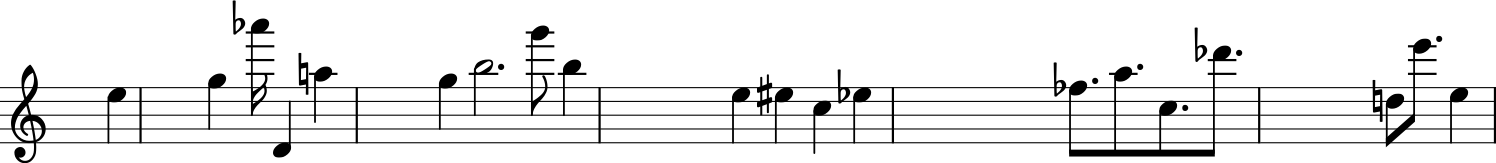

In [49]:
s = str2stream(string_s)

In [13]:
writemusic(s,'test.mid')

In [57]:
import datetime
import pickle
import time
import os
import shutil 


'''
Summary
    保存为音频数据
'''
def writemusic(s,path):
    #path = r'.\happy.mid' 
    s.write('midi', fp=path)
    

'''
Summary:
    制作数据集
Parameters:
    datas_num - 要制作的数据集的数量 int
'''
from shutil import copyfile,rmtree
def MakeDataSet(datas_num):
    nowtime = time.strftime("%Y-%m-%d_%H_%M_%S", time.localtime())
    dirname = nowtime[:-3]
    if os.path.exists('./wavDatasets/'+dirname):
        rmtree('./wavDatasets/'+dirname)
    if os.path.exists('./midiDatasets/'+dirname):
        rmtree('./midiDatasets/'+dirname)
    os.mkdir('./wavDatasets/'+dirname)
    os.mkdir('./midiDatasets/'+dirname)
    
    music_dic = {}
    for i in range(datas_num):
        string_s,string_list = MakeStrScore(20)
        file = nowtime+'_'+str(i)
        print(file)
        s = str2stream(string_s,False)
        writemusic(s,'./midiDatasets/{0}/{1}.mid'.format(dirname,file))
        music_dic[file] = string_list
        #path = 'midiDatasets\'+ datetime.datetime.now().strftime('%Y-%m-%d')
    
   
    
    data_output = open('./wavDatasets/{0}/music_dic.pkl'.format(dirname),'wb')
    pickle.dump(music_dic,data_output)
    data_output.close()
    print('java -jar midi2wav.jar ./midiDatasets/{0}'.format(dirname))
    os.system('java -jar midi2wav.jar ./midiDatasets/{0}'.format(dirname))
    for file in os.listdir('./midiDatasets/{0}'.format(dirname)):
        if file.find('.wav')>0: 
            copyfile('./midiDatasets/{0}/{1}'.format(dirname,file), './wavDatasets/{0}/{1}'.format(dirname,file))
            os.remove('./midiDatasets/{0}/{1}'.format(dirname,file))
            
    return music_dic
#     import time

# # 格式化成2016-03-20 11:45:39形式
# print (time.strftime("%Y-%m-%d_%H:%M:%S", time.localtime()))
#     import pickle
# import numpy as np

# your_data = np.ones((4,5),np.uint8)
# # wb 以二进制写入
# data_output = open('data.pkl','wb')
# pickle.dump(your_data,data_output)
# data_output.close()

# # rb 以二进制读取
# data_input = opne('data.pkl','rb')
# read_data = pickle.load(data_input)
# data_input.close(）
def GetMusicDic():
    with open('./wavDatasets/music_dic.pkl', 'rb') as file:
        music_dic = pickle.load(file)
    return music_dic
        

In [58]:
d = MakeDataSet(10)

2020-05-26_16_56_15_0
2020-05-26_16_56_15_1
2020-05-26_16_56_15_2
2020-05-26_16_56_15_3
2020-05-26_16_56_15_4
2020-05-26_16_56_15_5
2020-05-26_16_56_15_6
2020-05-26_16_56_15_7
2020-05-26_16_56_15_8
2020-05-26_16_56_15_9
java -jar midi2wav.jar ./midiDatasets/2020-05-26_16_56


In [28]:
time.strftime("%Y-%m-%d_%H_%M ", time.localtime())[:-4]

'2020-05-26_16'

In [66]:
for value in v:
    print(str2tone(value))

C4
G5
D5
F5
D4
D6b
G5
B6b
D5#
E5#
B5
G5
B4
D5
A5#
G5#
C5
F6#
G5
B5#


In [35]:
writemusic(s,r'.\random.mid')

In [ ]:
import wave

In [ ]:
path = r'.\star.mid' 
wv = wave.open(path, 'r')

In [ ]:
from midi2audio import FluidSynth

In [ ]:
fs = FluidSynth()

In [ ]:
fs.midi_to_audio(path, 'output.wav')

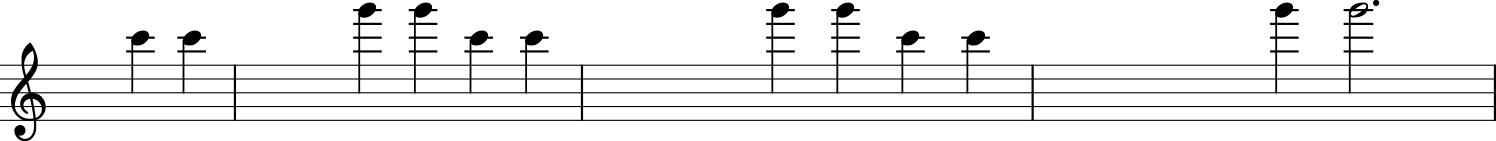

<music21.stream.Score mainScore>

In [9]:
s1 = '[11|5511|5511|55]--'
str2stream(s1)

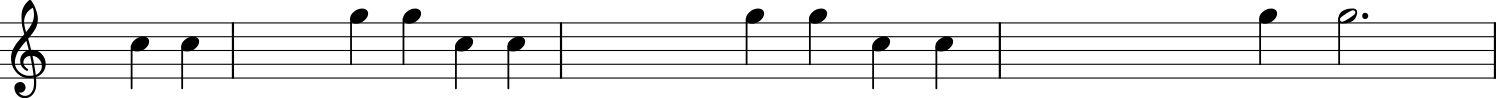

<music21.stream.Score mainScore>

In [11]:
s1 = '11|5511|5511|55---'
str2stream(s1)

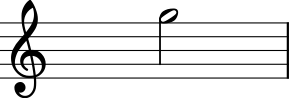

In [28]:
s1 = '5-'
stream1 = str2stream(s1)

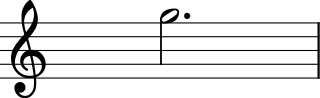

In [29]:
s1 = '5--'
stream1 = str2stream(s1)

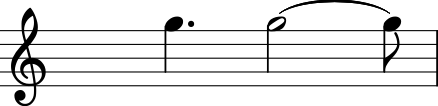

In [15]:
s1 = '5.5---'
stream2 = str2stream(s1)

In [17]:
stream1.show('text')

{1.0} <music21.stream.Measure 1 offset=1.0>
    {0.0} <music21.note.Note G>


In [18]:
stream2.show('text')

{1.0} <music21.stream.Measure 1 offset=1.0>
    {0.0} <music21.note.Note G>
    {1.5} <music21.note.Note G>


In [24]:
stream1[0][0].duration

<music21.duration.Duration 6.0>

In [25]:
stream2[0][1].duration

<music21.duration.Duration 6.0>

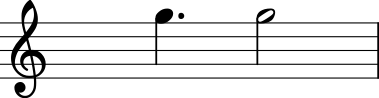

In [33]:
s1 = '5.5-'
stream1 = str2stream(s1)

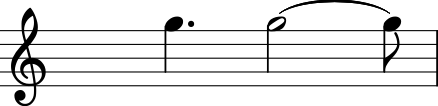

In [49]:
s1 = '5.5--'
stream2 = str2stream(s1)

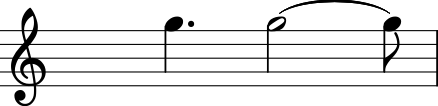

In [50]:
s1 = '5.5---'
stream3 = str2stream(s1)

In [48]:
stream2[0][1].duration.quarterLength

3.0

In [47]:
stream3[0][1].duration.quarterLength

6.0

In [40]:
stream2.show('text')

{1.0} <music21.stream.Measure 1 offset=1.0>
    {0.0} <music21.note.Note G>
    {1.5} <music21.note.Note G>


In [41]:
stream3.show('text')

{1.0} <music21.stream.Measure 1 offset=1.0>
    {0.0} <music21.note.Note G>
    {1.5} <music21.note.Note G>


In [44]:
s1 = '5---'
stream4 = str2stream(s1,False)

In [45]:
stream4[0][0].duration.quarterLength

6.0